# Работа с sentence-transformers

## Кластеризация текста

Из официальной документации: https://sbert.net/examples/applications/clustering/README.html

Импорт и просмотр данных:

In [ ]:
import pandas as pd

sentences_df = pd.read_csv('sentences.csv')

In [ ]:
sentences_df.head()

,Unnamed: 0,Cluster,Text
0,0,Природа и окружающая среда,"Мгновение, когда первый луч солнца пробивается..."
1,1,Природа и окружающая среда,Звуки далекого грома над долиной напоминают о ...
2,2,Природа и окружающая среда,"Ветер, проносящийся над вершинами деревьев, пр..."
3,3,Природа и окружающая среда,"Шепот рек и ручьев, пробивающихся сквозь камни..."
4,4,Природа и окружающая среда,"Каждый лист, падающий с дерева осенью, символи..."


Посмотрим на количество кластеров:

In [ ]:
len(sentences_df.Cluster.unique())

5

### Получение эмбеддингов

Список достпуных предобученных моделей: https://sbert.net/docs/sentence_transformer/pretrained_models.html

Установка библиотеки:

In [ ]:
!pip install sentence-transformers -q

Возьмем мультиязычную модель, которая обучалась для парафраза. Можно поискать и другие мультиязычные модели для другиз или множества задач.

In [ ]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Получаем эмбеддинги через encode():

In [ ]:
corpus_embeddings = embedder.encode(sentences_df.Text)

Как выглядят полученные эмбеддинги:

In [ ]:
corpus_embeddings

array([[ 0.01417967,  0.26333788,  0.04655688, ..., -0.06573692,
        -0.16863385,  0.17888965],
       [ 0.0484239 , -0.03492653,  0.00461436, ...,  0.02537572,
        -0.11644346, -0.06731887],
       [ 0.1008976 ,  0.10579806,  0.11023135, ..., -0.07221657,
        -0.3416561 , -0.12249409],
       ...,
       [ 0.06851684,  0.05274212, -0.10270707, ...,  0.1238013 ,
        -0.18730418, -0.08625282],
       [ 0.24685825, -0.27617896,  0.40528402, ...,  0.05812095,
        -0.04771053, -0.21370536],
       [ 0.07670908,  0.01431931, -0.35677922, ...,  0.13401496,
         0.00427535,  0.02361517]], dtype=float32)

Полученные эмбеддинги можно посмотреть на https://projector.tensorflow.org/.

Сохранение эмбеддингов:

In [ ]:
import numpy as np

# Сохранение в TSV
np.savetxt("embeddings_sentences.tsv", corpus_embeddings, delimiter="\t")

Сохранение метаданных (предложений):

In [ ]:
# Пример меток
labels = sentences_df.Text

# Сохранение меток в TSV
with open("metadata.tsv", "w") as f:
    for label in labels:
        f.write(f"{label}\n")

Если отобразим лейблы, то есть сами предложения, то увидим, что похожие предложения кучкуются рядом, и об этом же говорят ближайшие соседи. Например, в левом нижнем углу предложения касательно природы, а справа снизу — про современные технологии.

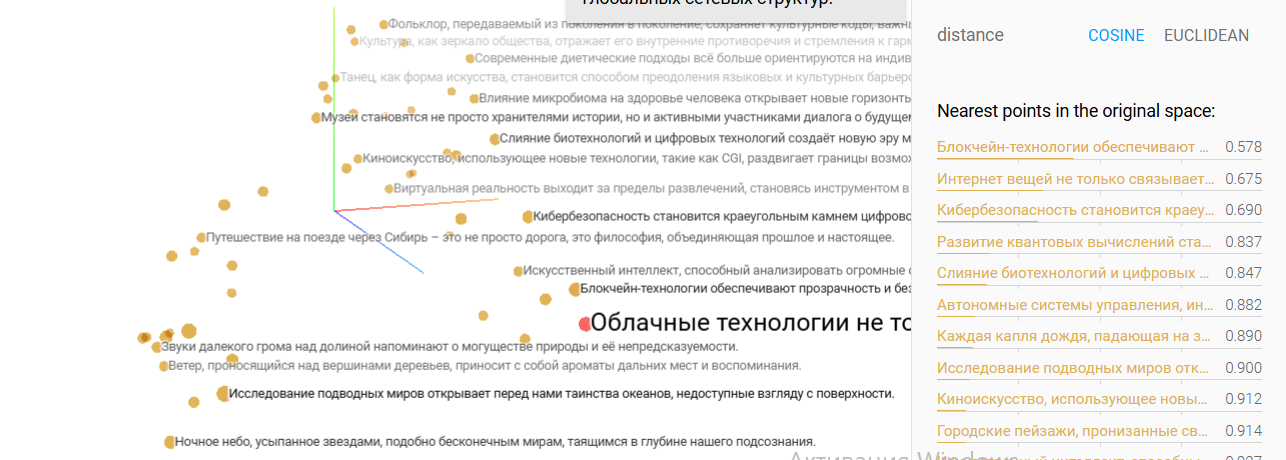

### Уменьшение размерности

Для уменьшения размерности эмбеддингов (размерность 384) возьмем UMAP.

In [ ]:
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00


Создание объекта UMAP с количеством получаемых компонент равным 3 (выходной вектор размерностью 3).

In [ ]:
import umap

umap_reducer = umap.UMAP(n_neighbors=5, n_components=3, random_state=42)

Сокращение эмбеддингов:

In [ ]:
embeds = umap_reducer.fit_transform(corpus_embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Создаем 3D-визуализацию сокращенных эмбеддингов:

In [ ]:
import plotly.express as px

fig = px.scatter_3d(embeds, x=embeds[:, 0], y=embeds[:, 1], z=embeds[:, 2], color=sentences_df.Cluster)
fig.show()

### Метод силуэта

Используем метод силуэта для определения начального числа кластеров:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px

# Функция для выбора оптимального количества кластеров
def optimal_number_of_clusters(X, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(embeds)
        score = silhouette_score(embeds, labels)
        silhouette_scores.append(score)
    return silhouette_scores

# Вычисление оптимального количества кластеров
silhouette_scores = optimal_number_of_clusters(embeds)

# Визуализация результатов с помощью Plotly
k_values = range(2, len(silhouette_scores)+2)
fig = px.line(x=k_values, y=silhouette_scores, labels={'x': 'Number of Clusters (k)', 'y': 'Silhouette Score'},
              title='Silhouette Score vs. Количество кластеров')
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

По методу силуэта нужно выбрать наибольшее среднее значение — напротив него будет оптимальное количество кластеров. У нас оно наблюдается на 2 и 10. В области эталонных 5-ти кластеров видим, что по сравнению с соседями (3, 4, 6, 7 кластеров) метрика выше.

### Кластеризация

Выполнение кластеризации и печать предложений из кластера:

In [ ]:
# Выполнение кластеризации
num_clusters = 5

# Создаем объект кластеризатора и кластеризуем
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeds)

# Получаем метки кластеров
cluster_assignment = clustering_model.labels_

# Создаем список списков и в список с номером кластера добавляем относящщеся к нему предложение
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences_df.Text[sentence_id])

# Печать
for i, cluster in enumerate(clustered_sentences):
    print("Кластер ", i + 1)
    print(cluster)
    print("")

Cluster  1
['Шепот рек и ручьев, пробивающихся сквозь камни, рассказывает истории времени и терпения.', 'Пляжи, омываемые бесконечными волнами океана, напоминают о цикличности времени и жизни.', 'Автономные системы управления, интегрированные в транспортные средства, уже изменили наше понимание личной мобильности.', 'Современное искусство все чаще обращается к вопросам экологии, поднимая важные социальные проблемы через призму творчества.', 'Музеи становятся не просто хранителями истории, но и активными участниками диалога о будущем общества.', 'Фольклор, передаваемый из поколения в поколение, сохраняет культурные коды, важные для идентичности народа.', 'Путешествия в отдаленные уголки планеты раскрывают перед нами не только природные красоты, но и культурные сокровища малых народов.', 'Пешие походы по горным тропам не только укрепляют тело, но и открывают новые горизонты для души.', 'Путешествие по железной дороге позволяет ощутить магию медленного перемещения через сменяющиеся пейзаж

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Полученную модель кластеризации можно сравнить с истинным распределением данных.

In [ ]:
fig = px.scatter_3d(embeds, x=embeds[:, 0], y=embeds[:, 1], z=embeds[:, 2], color=clustering_model.labels_)
fig.show()

## Эмбеддинги изображений

**Задача**: соотнести эмбеддинги описаний с эмбеддингам изображений.

In [ ]:
!pip install sentence-transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.0 MB/s eta 0:00:00


### О CLIP-ViT

> **CLIP** предназначена для понимания связи между изображениями и текстовыми описаниями, чтобы научиться сопоставлять изображения и текстовые описания, что позволяет ей выполнять задачи, связанные с визуальным распознаванием и текстовым описанием изображений.

> **ViT (Visual Transformer**) — архитектура нейронной сети, которая применяет трансформеры, изначально разработанные для обработки текста, к задачам компьютерного зрения.


<img src ="https://github.com/openai/CLIP/blob/main/CLIP.png?raw=true" width="900">

### Реализация

Импортируем предобученную модель, а также класс Image для работы с изображениями:

In [ ]:
from sentence_transformers import SentenceTransformer
from PIL import Image

# Загрузка CLIP-модели для английского языка
model = SentenceTransformer("clip-ViT-B-32")

Функция для кодирования картинки, предложений и вычисления сходства:

In [ ]:
def compare_img_to_text(img_path:str, description_texts:list=[]):
  # Кодирование (эмбеддинг) картинки
  img_emb = model.encode(Image.open(img_path))

  # Кодирование (эмбеддинг) описаний
  text_emb = model.encode(
      description_texts
  )

  # Высчитываем схожесть между эмбеддингами
  similarity_scores = model.similarity(img_emb, text_emb)
  similarity_scores = similarity_scores.tolist()[0]
  for description, score in zip(description_texts, similarity_scores):
      print(f"Description: {description}\nSimilarity Score: {score:.4f}\n")

Попробуем передать такую картинку и описать ее следующими предложениями:
- летящий кот
- собака на улице
- грибы в лесу
- закатный пляж

In [ ]:
scores = compare_img_to_text("/content/cat.png", [
    "A flying cat",
    "Dog on the street",
    "Mushrooms in the forest",
    "Sunset on the beach"
])

Description: A flying cat
Similarity Score: 0.2647

Description: Dog on the street
Similarity Score: 0.1892

Description: Mushrooms in the forest
Similarity Score: 0.1517

Description: Sunset on the beach
Similarity Score: 0.1826



Идентификация правильная — наибольшая оценка у "A flying cat" ("Летящий кот").

Ещё один пример: картинка строителя на объекте. Описания:
- шлем на голове
- собака на улице
- грибы в лесу
- закатный пляж
- строитель делает окно дома
- мужчина

In [ ]:
scores = compare_img_to_text("/content/builder.jpg", [
    "A helmet on head",
    "Dog on the street",
    "Mushrooms in the forest",
    "Sunset on the beach",
    "A builder making a window",
    "A man"
])

Description: A helmet on head
Similarity Score: 0.2289

Description: Dog on the street
Similarity Score: 0.1324

Description: Mushrooms in the forest
Similarity Score: 0.1210

Description: Sunset on the beach
Similarity Score: 0.0966

Description: A builder making a window
Similarity Score: 0.2691

Description: A man
Similarity Score: 0.1876



Идентификация правильная — наибольшие оценки у "A builder making a window" ("Строитель делает окно") и "A helmet on head" ("Шлем на голове").

# Работа с ruGPT

Попробуем поработать с уже готовыми языковыми моделями, например, от Сбера:
https://huggingface.co/ai-forever/rugpt3small_based_on_gpt2

Это малая модель для генерации текста, выпущенная в середине 2023 года. Она весит гораздо меньше по сравнению со своей сестрой ruGPT-3.5-13B на 13 миллиардов параметров. Из-за объема (вес больше 60Гб) последнюю использовать не будем, т.к. Colab не предоставляет столько места.

Как указывают разработчики, для обучения потребовалась неделя и 32 GPU.

Установка библиотеки transformers:

Документация по базовым классам для моделей и их токенизаторов: https://huggingface.co/transformers/v3.0.2/model_doc/gpt2.html

In [ ]:
!pip install transformers -q

In [ ]:
# Импорт модели и токенизатора из huggingface – библиотеки по работе с транформерными моделями
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
model_tokenizer_name = "ai-forever/rugpt3small_based_on_gpt2"

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(model_tokenizer_name) # загрузка дообученного токенизатора

model = GPT2LMHeadModel.from_pretrained(model_tokenizer_name) # загрузка дообученной модели

# model.cuda() # перевод модели на GPU, можно обойтись и без этого, тогда генерация будет происходить медленнее

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

В функцию для генерации текста передаётся предобученная модель, её токенизатор, и еще ряд параметров:


- **do_sample** — следует ли использовать выборку для генерации текста. Если True, то модель будет использовать вероятностное распределение для выбора следующего токена. Если False, то будет использоваться жадный поиск.
- **max_length** — максимальная длина генерируемого текста.
- **repetition_penalty** — параметр, который контролирует штраф за повторение токенов. Значение больше 1 уменьшает вероятность повторения токенов.
- **top_k** — ограничивает количество слов, которые могут быть выбраны на каждом шаге генерации, к самым вероятным k словам.
- **top_p** — определяет минимальный порог вероятности, при котором слова включаются в пул для выбора на каждом шаге.
- **temperature** — параметр, который управляет "мягкостью" выборки. Меньшие значения делают выборку более детерминированной, а большие значения — более случайной.
- **num_beams** — количество лучей для beam search. Если None, то beam search не используется.

Полученный текст кодируется с помощью токенизатора, и выход модели генерируется с помощью метода generate().

In [ ]:
def generate(
    model, tokenizer, text,
    do_sample=True, max_length=50, repetition_penalty=5.0,
    top_k=5, top_p=0.95, temperature=1,
    num_beams=None,
    no_repeat_ngram_size=3
    ):

  # Кодирование входной последовательности
  input_ids = tokenizer.encode(text, return_tensors="pt")

  # Генерация текста с параметрами
  out = model.generate(
      input_ids,
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      do_sample=do_sample,
      top_k=top_k, top_p=top_p, temperature=temperature,
      num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size
      )
  return list(map(tokenizer.decode, out))

Пробуем создать текст:

In [ ]:
generated = generate(model, tokenizer, "Однажды давным-давно ", num_beams=10)
generated[0]

'Однажды давным-давно  в одном маленьком городке жила маленькая девочка, которая очень любила рисовать. И вот однажды она пришла к художнику и попросила его нарисовать ее портрет. Художник ответил ей: &laquo;Я не художник&raquo'

Неплохой результат для маленькой модели.

In [ ]:
generated = generate(model, tokenizer, "Искусственный нейрон — это", num_beams=10)
generated[0]

'Искусственный нейрон — это то, что мы называем "искусственным интеллектом".  Он состоит из двух частей: внутренней и внешней.  Внутренняя часть содержит в себе информацию о том, как устроена наша мозговая система, а внешняя'

Яркий пример галлюцинации.

Переводим на CUDA:

In [ ]:
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

Небольшое изменение функции для генерации:

In [ ]:
def generate(
    model, tokenizer, text,
    do_sample=True, max_length=100, repetition_penalty=5.0,
    top_k=5, top_p=0.95, temperature=1,
    num_beams=None,
    no_repeat_ngram_size=3
    ):

  input_ids = tokenizer.encode(text, return_tensors="pt").cuda()

  out = model.generate(
      input_ids,
      max_length=max_length,
      repetition_penalty=repetition_penalty,
      do_sample=do_sample,
      top_k=top_k, top_p=top_p, temperature=temperature,
      num_beams=num_beams, no_repeat_ngram_size=no_repeat_ngram_size
      )
  return list(map(tokenizer.decode, out))

In [ ]:
generated = generate(model, tokenizer, "Николай Гоголь является известным", num_beams=10)
generated[0]

'Николай Гоголь является известным русским писателем-сатириком и сатириком.  Его произведения, в том числе "Мертвые души", "Братья Карамазовы" и др., были переведены более чем на 40 языков мира.  В России он был известен как один из основоположников русской юмористической прозы начала XX века. \n Сочинения Гоголя неоднократно переиздавались (в т.ч. посмертно), а также публиковались в журналах: "Новый мир", "'

Мы наглядно видим галлюцинации модели — то есть модель генерирует информацию, которая кажется правдивой, но неверна или не связана с входными данными. «Братья Карамазовы», очевидно, не произведение Гоголя.